# Sales Prediction

### Description
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

### Evaluation
Submissions are evaluated by root mean squared error **(RMSE)**. True target values are clipped into [0,20] range.

### Resources
Get the **RMSE** score: mean_squared_error(y_actual, y_predicted, squared=**False**)

## Data Set

### Set the Stage

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

path_to_source = r'..\data\sales_train.csv'
path_to_test = r'..\data\test.csv'
path_to_sub = r'..\data\test.csv'


# Get Data
df = pd.read_csv(path_to_source, parse_dates=['date'])

# Add columns
df['month'] = pd.to_numeric(df['date'].dt.month)
df['month'] = df['date'].dt.month.map("{:02}".format)
df['year'] = pd.to_numeric(df['date'].dt.year)

# Convert column data types
df['shop_id'] = pd.to_numeric(df['shop_id'])
df['item_id'] = pd.to_numeric(df['item_id'])

# Group sales by date, year, month, shop_id, and item_id
sales = df.groupby(['date', 'year', 'month', 'shop_id', 'item_id']) \
    .agg({'item_cnt_day' : 'sum', 'item_price' : 'sum'}) \
    .reset_index()

# Add sales and qty columns
sales['sales'] = pd.to_numeric(sales['item_price'])
sales['qty'] = pd.to_numeric(sales['item_cnt_day'])
sales = sales.round(decimals=0)

# Select what is needed
sales = sales[['date', 'year', 'month', 'shop_id', 'item_id', 'qty', 'sales']]

# Filters
sales = sales[(sales['item_id'] != 6066)]
sales = sales[sales['date'] < '2015-12-01']

# Order by date
sales = sales.sort_values(by='date')

### Build Datasets

In [2]:
# Daily overall sales
dy_sales = sales.groupby('date').agg({'sales': 'sum', 'qty': 'sum'})
dif_df = dy_sales.diff().fillna(0.0)
# Add deltas between each day for sales and qty
dy_sales['sales_delta'] = dif_df['sales']
dy_sales['qty_delta'] = dif_df['qty']

# Monthly overall sales
mth_overall = sales.groupby(['month']).agg({'sales': 'sum', 'qty': 'sum'})
dif_df = mth_overall.diff().fillna(0.0)
mth_overall['sales_delta'] = dif_df['sales']
mth_overall['qty_delta'] = dif_df['qty']
mth_overall = mth_overall.reset_index()

### Stationary Test

In [3]:
def adf_test(data: np.ndarray):
    result = adfuller(data, autolag='AIC')
    d = { 'ADF Statistic': result[0], 'p-value': "%.4f" % result[1], 'crit_values': result[4].items()}
    df = pd.DataFrame(d)
    return df


'''The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value 
interpretation is just the opposite of ADH test.'''
def kpss_test(data: np.ndarray):
    result = kpss(data, regression='c')
    d = {'KPSS Statistic': result[0], 'p-value': "%.4f" % result[1], 'crit_values': result[3].items()}
    df = pd.DataFrame(d)
    return df

arr = mth_overall['sales'].to_numpy()
adf_df = adf_test(arr)
kpss_df = kpss_test(arr)

c:\users\dhamacher\documents\azuredevops\mllab\ml-venv\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [4]:
adf_df

,ADF Statistic,p-value,crit_values
0,-3.122881,0.0249,"(1%, -4.9386902332361515)"
1,-3.122881,0.0249,"(5%, -3.477582857142857)"
2,-3.122881,0.0249,"(10%, -2.8438679591836733)"


In [5]:
kpss_df

,KPSS Statistic,p-value,crit_values
0,0.359292,0.0947,"(10%, 0.347)"
1,0.359292,0.0947,"(5%, 0.463)"
2,0.359292,0.0947,"(2.5%, 0.574)"
3,0.359292,0.0947,"(1%, 0.739)"


<AxesSubplot:xlabel='qty', ylabel='Count'>

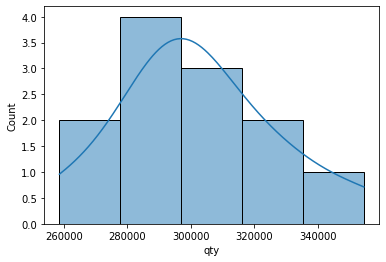

In [6]:
sns.histplot(mth_overall['qty'], kde=True)

<AxesSubplot:xlabel='qty_delta', ylabel='Count'>

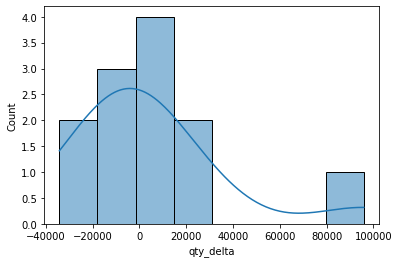

In [7]:
sns.histplot(mth_overall['qty_delta'], kde=True)

## Build Models
### Select Features and Predictor

In [8]:
mth = sales.groupby(['month', 'shop_id', 'item_id']).agg({'sales': 'sum', 'qty': 'sum'})
dif_df = mth.diff().fillna(0.0)
mth['sales_delta'] = dif_df['sales']
mth['qty_delta'] = dif_df['qty']
mth = mth.reset_index()

df = mth['sales_delta']
dif_df = df.diff().fillna(0.0)
mth['sales_delta_2'] = dif_df

mth['month'] = mth['month'].astype(np.int8)
mth['shop_id'] = mth['shop_id'].astype(np.int8)
mth['item_id'] = mth['item_id'].astype(np.int8)
mth['qty'] = mth['qty'].astype(np.int8)
mth['sales'] = mth['sales'].astype(np.int8)

unscaled = mth[['month', 'shop_id', 'item_id', 'qty']]
unscaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509918 entries, 0 to 1509917
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   month    1509918 non-null  int8 
 1   shop_id  1509918 non-null  int8 
 2   item_id  1509918 non-null  int8 
 3   qty      1509918 non-null  int8 
dtypes: int8(4)
memory usage: 5.8 MB


### Merge with Test Set

In [9]:
test = pd.read_csv(path_to_test, header=0)
test = test[['shop_id', 'item_id']]
test['month'] = '11'
test['qty'] = -1
test.head()

,shop_id,item_id,month,qty
0,5,5037,11,-1
1,5,5320,11,-1
2,5,5233,11,-1
3,5,5232,11,-1
4,5,5268,11,-1


In [10]:
frames = [unscaled, test]
full_set = pd.concat(frames)
full_set.shape

(1724118, 4)

### Get Train, and Test sets

In [11]:
X = pd.get_dummies(data=full_set, columns=['month', 'shop_id', 'item_id'])
X.shape

(1724118, 5406)

In [10]:
y = unscaled['qty']
y.shape

(1509918,)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
X_test

,qty,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,item_id_118,item_id_119,item_id_120,item_id_121,item_id_122,item_id_123,item_id_124,item_id_125,item_id_126,item_id_127
618238,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1377760,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1356685,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
592460,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388807,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026080,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
416533,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1393028,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1126587,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Model: Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test, y_pred)}') # RMSE: 3.282368218531396e-23

RMSE: 3.282368218531396e-23


# Model: Gradient Boost Regressor

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

est = GradientBoostingRegressor(n_estimators=4, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
score = mean_squared_error(y_test, est.predict(X_test))
print(f'RMSE: {score}')

RMSE: 12.062015558432329


# Prepare Kaggle Submission

### Load the Test Set

Valid!


In [37]:
df.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [39]:
df.head()

,shop_id,item_id,month,qty
0,5,5037,11,-1
1,5,5320,11,-1
2,5,5233,11,-1
3,5,5232,11,-1
4,5,5268,11,-1


In [32]:
unscaled.head()

,month,shop_id,item_id,qty
0,1,0,32,4
1,1,0,33,2
2,1,0,35,2
3,1,0,43,1
4,1,0,51,2


In [ ]:
frames = 